In [6]:
import pandas as pd
data=pd.read_csv("FAOLEX.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [7]:
import nltk
keywords=list(data["Keywords"])
country=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    if type(country[i])!=str:
        country[i]="NaN"
    keywords[i]=words.split(";")
    i+=1



In [3]:
#i=0

#for words in keywords:
 #   keywords[i]=words + [" "+country[i]]
  #  i+=1

In [9]:
print(keywords[15])

['marine fisheries', ' protected fishing area', ' fishery management and conservation', ' offences/penalties', ' crustaceans', ' fishing authorization', ' aquatic animals', ' authorization/permit', ' protection of species']


In [10]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [12]:
print(keywords[15])
print(stemmed_words[15])

['marine fisheries', ' protected fishing area', ' fishery management and conservation', ' offences/penalties', ' crustaceans', ' fishing authorization', ' aquatic animals', ' authorization/permit', ' protection of species']
['marine fisheri', ' protected fishing area', ' fishery management and conserv', ' offences/penalti', ' crustacean', ' fishing author', ' aquatic anim', ' authorization/permit', ' protection of speci']


In [13]:
# Find number of extinct domains
a= list(set(data["Repealed"]))
i=0
for words in a:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    a[i]=words.split(";")

    i+=1



In [14]:
# print different domains
a=sum(a,[])
i=0
for word in a:
        word=word.strip()
        a[i]=word
        i+=1

print(set(a))




{'Nan', 'Y'}


In [15]:
# Count number documents in a language
languages=list(data["Language of document"])
print(languages.count("English"))

53564


In [16]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


/Users/gustavnielsen/Documents/Fagprojekt/top2vec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-02 21:30:34,344 - top2vec - INFO - Pre-processing documents for training
2023-05-02 21:30:40,731 - top2vec - INFO - Creating joint document/word embedding
2023-05-02 21:33:39,076 - top2vec - INFO - Creating lower dimension embedding of documents
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-05-02 21:35:41,590 - top2vec - INFO - Finding dense areas of documents
2023-05-02 21:35:47,563 - top2vec - INFO - Finding topics


In [18]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1437, 1415, 1306, ...,   20,   20,   19])

In [20]:
model.get_num_topics()

1141

In [62]:
topic_words,word_scores,topic_nums = model.get_topics(20)

In [63]:
print(topic_words)

[['mesh' 'fishing' 'cartilaginous' 'method' 'charge' 'commercial'
  'fisheries' 'bycatch' 'seasons' 'crustaceans' 'catch' 'size' 'gear'
  'allowable' 'diadromous' 'total' 'landing' 'fishery' 'fishes'
  'artisanal' 'allocation' 'vessel' 'mammals' 'quota' 'turtles'
  'molluscs' 'transshipment' 'prohibited' 'migratory' 'port' 'foreign'
  'marine' 'enhancement' 'seas' 'stock' 'illegal' 'state' 'unreported'
  'high' 'iuu' 'repopulation' 'mariculture' 'unregulated' 'aquatic'
  'coral' 'methods' 'inland' 'exclusive' 'hunting' 'birds']
 ['seeds' 'floriculture' 'variety' 'fibre' 'planting' 'material' 'plant'
  'breeders' 'oleaginous' 'legumes' 'vegetables' 'cereals' 'fruits'
  'weeds' 'rice' 'grains' 'nuts' 'beet' 'cane' 'tobacco' 'crops'
  'viticulture' 'quarantine' 'intellectual' 'biological' 'certification'
  'oenological' 'edible' 'production' 'pests' 'cocoa' 'coffee' 'tea'
  'post' 'packaging' 'biotechnology' 'sugar' 'internal' 'gmo' 'genetic'
  'trade' 'wood' 'diseases' 'ipm' 'commodities

In [51]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 54367, Score: 0.9761812090873718
-----------
animal health cattle pests/diseases
-----------

Document: 150102, Score: 0.9751607775688171
-----------
animal health pests/diseases cattle
-----------

Document: 52663, Score: 0.9700302481651306
-----------
cattle pests/diseases animal health
-----------

Document: 54661, Score: 0.9699968695640564
-----------
animal health cattle pests/diseases
-----------

Document: 142552, Score: 0.9632805585861206
-----------
animal health pests/diseases cattle
-----------

Document: 22053, Score: 0.962979793548584
-----------
animal health pests/diseases hygiene/sanitary procedures cattle
-----------

Document: 17646, Score: 0.9627536535263062
-----------
animal health pests/diseases cattle
-----------

Document: 7222, Score: 0.9626073837280273
-----------
animal health pests/diseases hygiene/sanitary procedures cattle
-----------

Document: 111189, Score: 0.9611528515815735
-----------
animal health pests/diseases cattle
-----------

Documen

In [59]:
# Check documents
#data.iloc[54661]

In [195]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["denmark"], num_topics=3)
print(topic_words)
print(topic_nums)

[array(['greenland', 'allocation', 'catch', 'fishing', 'allowable',
       'fishery', 'bycatch', 'quota', 'fishes', 'crustaceans', 'marine',
       'total', 'size', 'cartilaginous', 'mesh', 'fisheries', 'svalbard',
       'seasons', 'gear', 'diadromous', 'method', 'vessel', 'landing',
       'molluscs', 'prohibited', 'commercial', 'denmark', 'turtles',
       'transshipment', 'charge', 'migratory', 'iceland', 'mammals',
       'area', 'foreign', 'norway', 'territorial', 'port', 'conservation',
       'seas', 'sea', 'exclusive', 'high', 'fee', 'eez', 'harbour', 'is',
       'jurisdiction', 'continental', 'shelf'], dtype='<U15'), array(['qatar', 'bahrain', 'kuwait', 'nuclear', 'oman', 'sweden',
       'arabia', 'singapore', 'procedural', 'emirates', 'matters',
       'natural', 'iraq', 'greece', 'saudi', 'energy', 'gas', 'denmark',
       'coral', 'hydropower', 'latvia', 'radiation', 'coal', 'palestine',
       'aquatic', 'israel', 'prohibited', 'fee', 'north', 'sinking',
       'guam', 

In [61]:
topic_mapping = model.hierarchical_topic_reduction(num_topics=200)

KeyboardInterrupt: 

In [197]:
print(model.topic_words_reduced)

[['steroids' 'hormones' 'mrl' 'residue' 'drugs' 'limit' 'hygiene'
  'maximum' 'swine' 'procedures' 'residues' 'sanitary' 'feed'
  'feedstuffs' 'veterinary' 'animal' 'toxicity' 'poultry' 'poisoning'
  'equine' 'slaughtering' 'meat' 'cattle' 'sheep' 'vaccination' 'goats'
  'additives' 'health' 'dairy' 'mercosur' 'safety' 'disinfestation'
  'codex' 'inspection' 'rodents' 'treated' 'haccp' 'disinfection'
  'andean' 'edible' 'packaging' 'pests' 'traceability' 'trade'
  'antimicrobial' 'diseases' 'welfare' 'labelling' 'milk' 'alimentarius']
 ['equine' 'sheep' 'swine' 'goats' 'cattle' 'rodents' 'herd' 'camelids'
  'book' 'reproduction' 'poultry' 'animal' 'slaughtering' 'vaccination'
  'mercosur' 'animals' 'welfare' 'meat' 'health' 'disinfestation' 'birds'
  'jersey' 'hygiene' 'sericulture' 'apiculture' 'steroids' 'hormones'
  'drugs' 'procedures' 'disinfection' 'quarantine' 'identification'
  'north' 'pests' 'feed' 'sanitary' 'ranching' 'inspection' 'marking'
  'captive' 'diseases' 'edible' '

In [202]:
model.topic_words_reduced[4]

array(['viticulture', 'oenological', 'tribunal', 'court', 'herzegovina',
       'beverages', 'tobacco', 'geographical', 'bosnia', 'indication',
       'fraud', 'settlement', 'codex', 'inspection', 'lao',
       'compensation', 'dispute', 'intellectual', 'labelling', 'trade',
       'certification', 'justice', 'practices', 'consumer', 'lanka',
       'liability', 'packaging', 'deceit', 'information', 'plant',
       'haccp', 'traceability', 'alimentarius', 'offences', 'internal',
       'tristan', 'adulteration', 'classification', 'singapore',
       'breeders', 'access', 'seeds', 'commodities', 'vested', 'sugar',
       'floriculture', 'veterinary', 'liechtenstein', 'legal',
       'agricultural'], dtype='<U14')

In [82]:
topic_words,word_scores,topic_nums = model.get_topics(10)
topic_words

array([['mesh', 'fishing', 'seasons', 'size', 'fishery', 'method',
        'cartilaginous', 'catch', 'bycatch', 'fisheries', 'landing',
        'prohibited', 'marine', 'total', 'allowable', 'charge',
        'allocation', 'fishes', 'vessel', 'gear', 'quota', 'artisanal',
        'foreign', 'commercial', 'diadromous', 'port', 'migratory',
        'transshipment', 'turtles', 'mammals', 'molluscs', 'crustaceans',
        'illegal', 'high', 'seas', 'inland', 'iuu', 'territorial',
        'unregulated', 'area', 'exclusive', 'state', 'eez',
        'enhancement', 'management', 'conservation', 'coral',
        'unreported', 'repopulation', 'sea'],
       ['floriculture', 'planting', 'seeds', 'material', 'fibre',
        'plant', 'cane', 'beet', 'variety', 'vegetables', 'breeders',
        'oleaginous', 'legumes', 'fruits', 'edible', 'nuts', 'sugar',
        'certification', 'rice', 'tobacco', 'cereals', 'labelling',
        'weeds', 'crops', 'oenological', 'production', 'packaging',
        '

In [66]:
# Tæl hvor mange der er repealed inden for et dato interval
dates=data["Date of original text"]
repealed=data["Repealed"]
antal=0
for i in range(1800,2022):
    c=dates==str(i)
    d=repealed=="Y"
    antal+=sum(c*d)
print(antal)


965


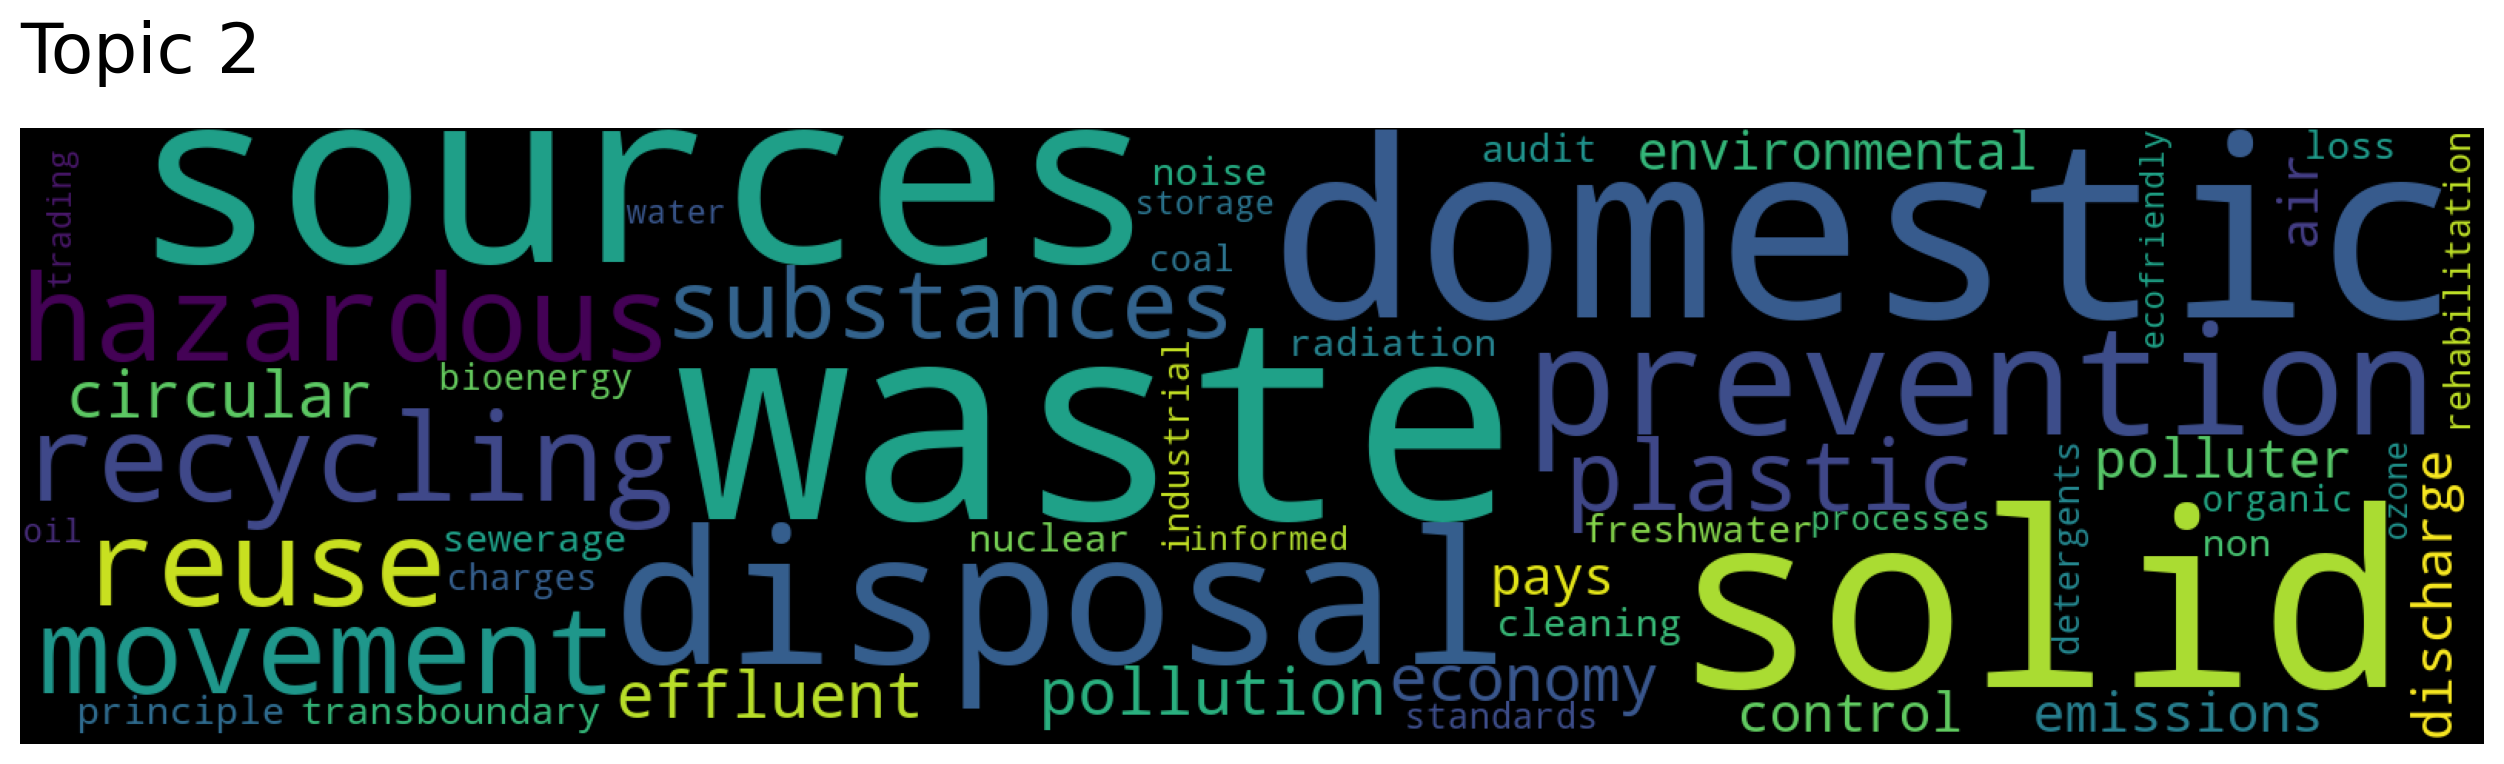

In [80]:
model.generate_topic_wordcloud(2)
# 167 kunne godt være fødevare og børn

- Cluster topics
- Dendogram